MPC for LTI systems and quadratic cost, with piecewise constant reference tracking and constraint relaxation if infeasibility occurs due to reference changes.

In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots 
import control as ct # control systems library
import cvxpy as cp
import scipy as sp
from collections import namedtuple
import time as tt
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

Utility functions

In [2]:
def terminal_cost_set_with_relax(p):
    '''
    Computes an ellipsoidal terminal set x^T * Qt * x <= 1 and an associated terminal cost
    x^T * P * x, on the basis of a nominal controller computed with the same cost weights as the MPC problem
    p: MPC controller parameters
    returns terminal cost matrix P, ellipsoidal terminal set matrix Qt and a
    status variable to check if the terminal set is empty or unbounded
     '''
    # Terminal controller, computed as an LQR
    K, P, _ = ct.dlqr(p.A, p.B, p.Q, p.R)
    K = -K
    
    # State constraints under the nominal controller
    if p.alpharelax is None:
        # No state constraint relaxation: consider hard constraints in terminal set
        Z = np.vstack((p.F,p.E @ K))
        z = np.vstack((p.f, p.e))
    else:
        # State constraints are relaxed: only input constraints must be enforced
        Z = p.E @ K
        z = p.e
        
    (nz, _) = Z.shape
    (n, _) = p.A.shape

    # Compute the maximal sublevel set of the terminal cost x^T * P * x
    # that lies within the constraints for the terminal controller
    a = cp.Variable(nz)
    gamma = cp.Variable(1)
    epsi = np.finfo(float).eps*0.0

    constraints = [gamma >= epsi]
    for i in range(nz):
        constraints += [a[i] >= epsi]
        M2 = cp.bmat([[gamma*P, np.zeros([n,1])],[np.zeros([1,n]), [[-1]]]])
        M1 = cp.bmat([[np.zeros([n,n]), 0.5*Z[i,:].reshape(1,-1).T], [0.5*Z[i,:].reshape(1,-1), -z[i,:].reshape(1,-1)]])
        constraints += [-a[i]*M1 + M2 >> 0]

    problem = cp.Problem(cp.Minimize(gamma), constraints)
    problem.solve(solver='MOSEK')
    if problem.status == 'unbounded':
        display("WARNING: terminal set is unbounded: is your problem even constrained?",
               "If not, use LQR :) ")
        Qt = np.zeros([n,n])
    elif problem.status == 'optimal':
        # Terminal set is defined by x^T * Qt * x <= 1
        Qt = gamma.value * P
    elif problem.status == 'infeasible':
        display("WARNING: terminal set is empty: probably the origin",
                "is in the infeasible region, is your problem overconstrained?")
        Qt = -1 * np.eye(n)
    else:
        raise(ValueError, "Solver error in computing terminal set")
    return P, Qt, problem.status

In [3]:
def sampled_data_controller(controller, plant_dt): 
    """
    Create a discrete-time system that models the behaviour 
    of a digital controller. 
    
    The system that is returned models the behavior of a sampled-data 
    controller, including a sampler and a ZOH converter. 
    The returned system is discrete-time, and its timebase `plant_dt` is 
    much smaller than the sampling interval of the controller, 
    `controller.dt`, to insure that continuous-time dynamics of the plant 
    are accurately simulated. This system must be interconnected
    to a plant with the same dt. The controller's sampling period must be 
    greater than or equal to `plant_dt`, and an integral multiple of it. 
    The plant that is connected to it must be converted to a discrete-time 
    ZOH equivalent with a sampling interval that is also `plant_dt`. A 
    controller that is a pure gain must have its `dt` specified (not None). 
    """
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    y = np.zeros((controller.noutputs, 1))

    def updatefunction(t, x, u, params):  
        nonlocal step

        # Update the controller state only if it is time to sample
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0

        return x
           
    def outputfunction(t, x, u, params):
        nonlocal y
        
        # Compute controller action if it is time to sample
        if step == 0:
            y = controller._out(t, x, u)       
        return y

    # Return the controller system object
    return ct.ss(updatefunction, outputfunction, dt=plant_dt, 
                 name=controller.name, inputs=controller.input_labels, 
                 outputs=controller.output_labels, states=controller.state_labels)

In [4]:
def quadratic_mpc_problem_with_relax(p):
    """
    Generate a cvxpy problem for the quadratic MPC step with possible soft state constraints
    p: Controller parameters
        A,B: Model
        N: Horizon length
        Q, R: State and input weights for stage cost
        Fx <= f: State constraints
        Eu <= e: Input constraints
        alpharelax: State constraint violation weight in cost function (None = no relaxation)
        Xf: if == None, use the trivial zero terminal constraint
            if == 'lqr', compute an ellipsoidal terminal set
            and quadratic terminal cost based on lqr with weights Q, R
    Parameters (cvxpy):
    x0: initial state
    returns cvxpy problem object
    """
    
    # State and input dimension
    (nx, nu) = p.B.shape
    # Number of state and input constraints
    nf, _ = p.F.shape
    ne, _ = p.E.shape

    # Define initial state as parameter  
    x0 = cp.Parameter(nx, name='x0')
    
    # Define state and input variables
    x = cp.Variable((nx, p.N + 1), name='x') # From k=0 to k=N
    u = cp.Variable((nu, p.N), name='u')     # From k=0 to k=N-1

    # If parameter alpharelax is a value, make the state constraints soft
    if p.alpharelax is not None:
        # State constraints are required to be soft
        if p.alpharelax <= 0:
            raise(ValueError, "p.alpharelax must be positive")
        # Introduce slack variables for soft constraints
        epsilonrelax = cp.Variable((nf, p.N), name='epsilon')

    # Initialize cost and constraints
    cost = 0.0
    constraints = []
    
    # Generate cost and constraints
    for k in range(p.N):
        
        # Stage cost
        cost += cp.quad_form(x[:, k], p.Q)
        cost += cp.quad_form(u[:, k], p.R)
        
        if p.alpharelax is not None:
            # Add slack variable penalization in cost if constraints are soft
            cost += p.alpharelax * cp.quad_form(epsilonrelax[:, k], np.eye(nf))

        # Dynamics constraint
        constraints += [x[:, k + 1] == p.A @ x[:, k] + p.B @ u[:, k]]

        # Input constraints
        if p.E is not None:
            constraints += [p.E @ u[:,k] <= p.e.reshape(-1)]  

        # State constraints
        if p.F is not None:
            if p.alpharelax is not None:
                # Make state constraints soft using slacks
                constraints += [p.F @ x[:, k] <= p.f.reshape(-1) + epsilonrelax[:, k] ]
            else:
                # Make state constraints hard
                constraints += [p.F @ x[:, k] <= p.f.reshape(-1)]
        
    # Terminal cost and constraint:
    # if unspecified, fall back to trivial terminal constraint
    if p.Xf == 'lqr': # Ellipsoidal/lqr set/cost
        # Add terminal cost
        cost += cp.quad_form(x[:, p.N], p.P)
        # Enforce terminal set
        constraints += [cp.quad_form(x[:, p.N], p.Qt) <= 1]
    else:
        constraints += [x[:, p.N] == np.zeros_like(x0) ]
    
    # Initial state constraint
    constraints += [x[:, 0] == x0]

    # Generate cvx problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    # Return problem object
    return problem

In [5]:
def mpc_controller_with_relax(parameters, T, **kwargs):
    """
        Create an I/O system implementing an MPC controller with tracking 
        State constraints get automatically relaxed in case of infeasibility
        parameters: Controller parameters
            A,B: Model
            N: Horizon length
            Q,R: Cost weights
        T: Sampling period
    """

    p = parameters
    # Dimensions
    nx, nu = p.B.shape
    no, _ = p.C.shape

    # Map from references to steady-state inputs and states for tracking
    Wsp = np.linalg.inv(np.block([ 
         [np.eye(nx)-p.A, -p.B],
         [p.C, np.zeros([no,nu]) ] ]))
    
    # This variable holds the last reference value
    lastref = np.zeros(no)

    # State and input at set point, initialize at zero
    xsp = np.zeros([nx,1])
    usp = np.zeros([nu,1])

    # Compute initial terminal set for zero reference (may change if reference changes)
    if p.Xf == 'lqr':
        p.P, p.Qt, status = terminal_cost_set_with_relax(p)
        if status == 'unbounded':
            dummy = 0 # Do nothing
        # Terminal set is unbounded: Qt=0
        elif status == 'infeasible':
            # Terminal set is empty: the constraint set is probably empty
            display("Terminal set is empty: falling back to zero terminal", 
                    "constraint but something is probably wrong with your",
                    "constraints, expect infeasibility")

    # Generate cvxpy problem
    problem = quadratic_mpc_problem_with_relax(p)

    # This function updates the mpc problem when reference changes
    def update_mpc_problem(ref, t):
        nonlocal p, nx, nu, no, Wsp, xsp, usp, problem

        # Compute state and input at new set point
        xusp = Wsp@np.vstack([np.zeros([nx,1]), ref.reshape([no,1])])
        xsp = xusp[:nx]
        usp = xusp[-nu:]  

        # Compute new constraints on error states and error inputs (p.fa and p.ea hold the initial f and e matrices)
        p.f = p.fa - p.F @ xsp
        p.e = p.ea - p.E @ usp
        
        # Update terminal set
        p.P, p.Qt, status = terminal_cost_set_with_relax(p)
        if status == 'unbounded':
            # Terminal set is unbounded: enforce no terminal constraint
            dummy = 0 # Do nothing       
        elif status == 'infeasible':
            # Terminal set for new reference is empty: trigger relaxation and recompute terminal set
            display(f"Relaxation triggered for empty terminal set at t={t}")
            p.alpharelax = 100
            p.P, p.Qt, status = terminal_cost_set_with_relax(p)
            if status != 'optimal':
                # If we get here, the input violates the constraints at the set point
                # and hence the set point is impossible to reach, give up
                raise(ValueError("The terminal set with relaxed state constraints is empty",
                                 "It is likely that the input violates the constraints at set point, giving up"))
            
        # Generate updated problem
        problem = quadratic_mpc_problem_with_relax(p)

    
    # Controller state update function
    def _update(t, x, u, params={}):
        nonlocal xsp, usp, nu, nx, problem, lastref, p

        # On the first try at each step, never relax
        p.alpharelax=None
 
        # Retrieve current plant state (last nx components of u)
        x0 = u[-nx:]
            
        # Retrieve current reference (first no components of u)
        ref = u[:no]

        # See if the reference changed. If so, update problem
        if not np.array_equal(lastref, ref):
            lastref = ref
            update_mpc_problem(ref, t)
               
        # Pass parameters to cvxpy
        problem.param_dict['x0'].value = x0-xsp.reshape(-1)
                
        # Solve optimization problem
        problem.solve(solver='MOSEK', warm_start=True)
        
        if problem.status != 'optimal':
            # The optimization problem is infeasible: we try relaxing unless we are relaxing already
            if p.alpharelax is not None:
                # The relaxed problem is infeasible: give up 
                raise(ValueError("Infeasible relaxed problem: giving up"))
            else:
                # Generate and solve a relaxed problem with soft state constraints
                display(f"Relaxation triggered for infeasibility at t={t}")
                p.alpharelax = p.alpharelaxe
                p.P, p.Qt, status = terminal_cost_set_with_relax(p)
                problem = quadratic_mpc_problem_with_relax(p)
                # Solve again 
                problem.param_dict['x0'].value = x0-xsp.reshape(-1)
                problem.solve(solver='MOSEK', warm_start=True)
                if problem.status != 'optimal':
                    # We are infeasible on the relaxation: give up 
                    raise(ValueError("Infeasible relaxed problem: giving up"))
                    
    
        # Retrieve solution (optimal sequence)
        res = problem.var_dict['u'].value
        # New state is the optimal sequence: return it
        return res

        
    # Controller output computation
    def _output(t, x, u, params={}):
        nonlocal xsp, usp, nu, nx, problem, lastref, p

        # On the first try at each step, never relax
        p.alpharelax=None
 
        # Retrieve current plant state (last nx components of u)
        x0 = u[-nx:]
            
        # Retrieve current reference (first no components of u)
        ref = u[:no]

        # See if the reference changed. If so, update problem
        if not np.array_equal(lastref, ref):
            lastref = ref
            update_mpc_problem(ref, t)
               
        # Pass parameters to cvxpy
        problem.param_dict['x0'].value = x0-xsp.reshape(-1)
                
        # Solve optimization problem
        problem.solve(solver='MOSEK', warm_start=True)
        
        if problem.status != 'optimal':
            # The optimization problem is infeasible: we try relaxing unless we are relaxing already
            if p.alpharelax is not None:
                # The relaxed problem is infeasible: give up  
                raise(ValueError("Infeasible relaxed problem: giving up"))
            else:
                # Generate and solve a relaxed problem with soft state constraints
                display(f"Relaxation triggered for infeasibility at t={t}")
                p.alpharelax = p.alpharelaxe
                p.P, p.Qt, status = terminal_cost_set_with_relax(p)
                problem = quadratic_mpc_problem_with_relax(p)
                # Solve again 
                problem.param_dict['x0'].value = x0-xsp.reshape(-1)
                problem.solve(solver='MOSEK', warm_start=True)
                if problem.status != 'optimal':
                    # We are infeasible on the relaxation: give up 
                    raise(ValueError("Infeasible relaxed problem: giving up"))
                    
        # Retrieve solution (optimal sequence)
        res = problem.var_dict['u'].value
        # Return first sample, plus set point offset
        uout = res[:,0]+usp.reshape(-1)
        return uout
               
                
    # Number of states of the controller: last input sequence
    kwargs['states'] = nu * p.N
        
    return ct.NonlinearIOSystem(_update, _output, dt=T, **kwargs)

Main program

In [6]:
A1=A3=28
A2=A4=32
a1=a3=0.071
a2=a4=0.057
kc=1
g=981
h10=12.6
h20=13
h30=4.8
h40=4.9
v01=3.15
v02=3.15
k1=3.14
k2=3.29
g1=0.43
g2=0.34
hmax=19

T1=A1/a1*np.sqrt(2*h10/g)
T2=A2/a2*np.sqrt(2*h20/g)
T3=A3/a2*np.sqrt(2*h20/g)
T4=A4/a2*np.sqrt(2*h20/g)

# Continuous-time plant model
A = np.array([ [-1/T1, 0, A3/A1/T3, 0],
    [0, -1/T2, 0, A4/A2/T4],
    [0, 0, -1/T3, 0],
    [0, 0, 0, -1/T4 ]])
B = np.array([[g1*k1/A1, 0],
    [0, g2*k2/A2],
    [0, (1-g2)*k2/A3],
    [(1-g1)*k1/A4, 0]])

C = np.array([[kc, 0,0,0],
    [0, kc, 0, 0]])
D = np.zeros([2,2])

(no,nx) = C.shape
_, nu = B.shape

# Need to output both the actual output and the state
Ctot = np.vstack((C, np.eye(nx)))
Dtot = np.vstack((D, np.zeros([nx,nu])))

plant_continuous = ct.ss(A,B,Ctot,Dtot, 
                   inputs=['u[0]','u[1]'], states=['x[0]','x[1]','x[2]','x[3]'],
                   outputs=['y[0]','y[1]','x[0]','x[1]','x[2]','x[3]'])

# This is the step to simulate the continuous time plant (and the closed loop)
simulation_dt = 1
# Generate a discrete-time simulator of the plant with the simulation step
plant_simulator = ct.c2d(plant_continuous, simulation_dt, 'zoh')

# Controller sampling time
T = 10

# Generate discretized plant model for use with the controller
plant_discrete = ct.c2d(plant_continuous, T, 'zoh')

# MPC controller parameter structure field names
p = namedtuple('parameters', ['A','B','C','N','Q','R','F','f','fa','E','e','ea','Xf','P','Qt','alpharelax','alpharelaxe'])

# Cost weights
p.Q = np.eye(4)
p.R = np.eye(2)

# Horizon length
p.N = 48

# Model
p.A = plant_discrete.A
p.B = plant_discrete.B
p.C = C

# State constraints
y1min = -h10
y1max = hmax-h10
y2min = -h20
y2max = hmax-h20
y3min = -h30
y3max = hmax-h30
y4min = -h40
y4max = hmax-h40
p.F = np.array([[1, 0, 0, 0],
                [-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, -1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1],
                [0, 0, 0, -1]])

p.f = np.array([[y1max],  
                [-y1min],
                [y2max],
                [-y2min],
                [y3max],  
                [-y3min],
                [y4max],
                [-y4min]])

display(p.f)

# Input constraints
vmax = 4
u1min = -v01
u1max = vmax-v01
u2min = -v02
u2max = vmax-v02
p.E = np.array([[1, 0],
                [-1, 0],
                [0, 1],
                [0, -1]])

p.e = np.array([[u1max],
                [-u1min],
                [u2max],
                [-u2min]])

display(p.e)

# This holds the initial f when reference changes
p.fa = p.f
# This holds the initial e when reference changes
p.ea = p.e


# Terminal set type
p.Xf = 'lqr'

# Start by not relaxing costraints
p.alpharelax = None

# Penalty on state constraint violation when relaxation is triggered
p.alpharelaxe = 100

array([[ 6.4],
       [12.6],
       [ 6. ],
       [13. ],
       [14.2],
       [ 4.8],
       [14.1],
       [ 4.9]])

array([[0.85],
       [3.15],
       [0.85],
       [3.15]])

/Users/giannibi/anaconda3/envs/rpc25/lib/python3.10/site-packages/cvxpy/expressions/expression.py:889: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


'Minlevel: '

array([6.26468875])

'Maxlevel: '

array([18.3182345])

/Users/giannibi/anaconda3/envs/rpc25/lib/python3.10/site-packages/cvxpy/expressions/constants/constant.py:52: UserWarning: Initializing a Constant with a nested list is undefined behavior. Consider using a numpy array instead.
  warnings.warn(NESTED_LIST_WARNING)
/Users/giannibi/anaconda3/envs/rpc25/lib/python3.10/site-packages/control/statesp.py:1739: FutureWarning: using ss() to create nonlinear I/O systems is deprecated; use nlsys()
  warn("using ss() to create nonlinear I/O systems is deprecated; "
/Users/giannibi/anaconda3/envs/rpc25/lib/python3.10/site-packages/cvxpy/expressions/constants/constant.py:52: UserWarning: Initializing a Constant with a nested list is undefined behavior. Consider using a numpy array instead.
  warnings.warn(NESTED_LIST_WARNING)
/Users/giannibi/anaconda3/envs/rpc25/lib/python3.10/site-packages/cvxpy/expressions/constants/constant.py:52: UserWarning: Initializing a Constant with a nested list is undefined behavior. Consider using a numpy array instead.
 

'Simulation time:'

22.932424068450928

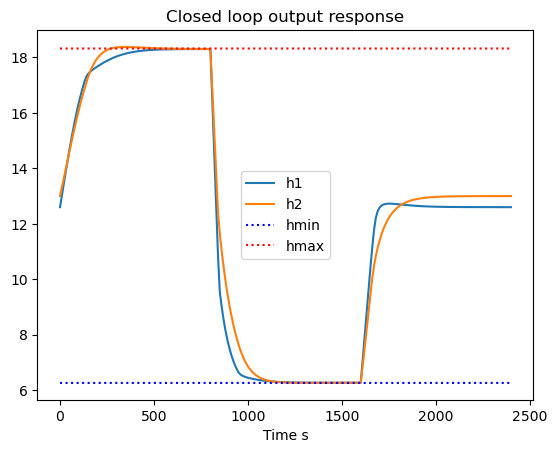

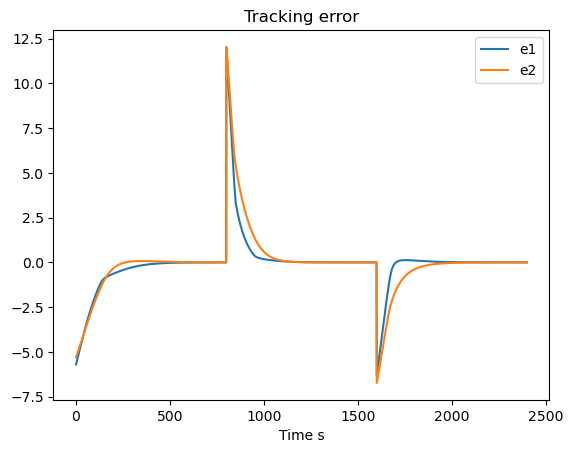

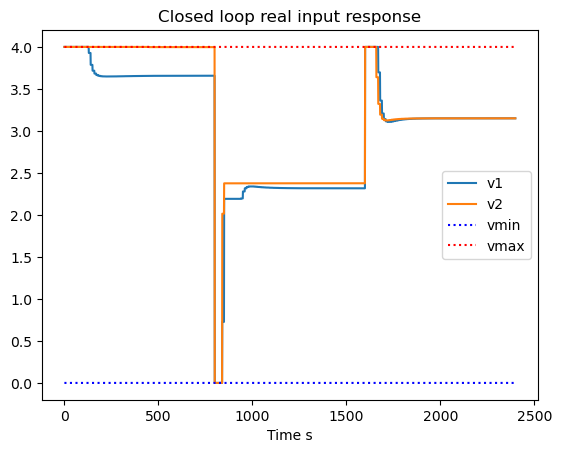

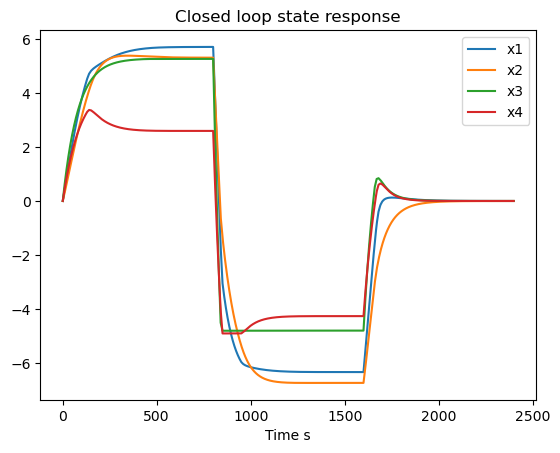

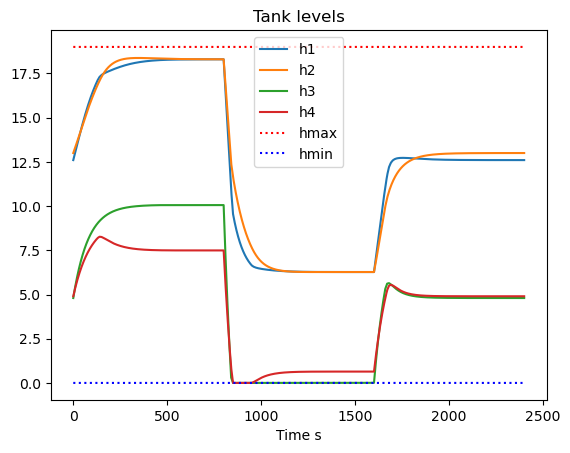

In [7]:
# Compute the maximal set points, lower and upper
gamma = cp.Variable(1)
xinf = cp.Variable([nx,1])
uinf = cp.Variable([nu,1])
WW = cp.bmat([ [np.eye(nx)-p.A, -p.B],
         [p.C, np.zeros([no,nu]) ] ])
refe = cp.vstack([gamma-h10,gamma-h20])
zrefe = cp.vstack([np.zeros([nx,1]), refe.reshape([no,1])])
xu = cp.vstack([xinf,uinf])
constr = [ WW@xu == zrefe ]
constr += [ p.F@xinf <= p.f ]
constr += [ p.E@uinf <= p.e ]
problem = cp.Problem(cp.Minimize(gamma), constr)
problem.solve(solver='MOSEK')
minlevel = gamma.value
display("Minlevel: ",minlevel)
problem = cp.Problem(cp.Maximize(gamma), constr)
problem.solve(solver='MOSEK')
maxlevel = gamma.value
display("Maxlevel: ",maxlevel)


# Define the MPC controller system object
controller = mpc_controller_with_relax(p, T, 
                            inputs=['ref[0]','ref[1]','x[0]','x[1]','x[2]','x[3]'],
                            outputs=['u[0]','u[1]'])

# Create model of controller for simulation with the same integration time
# as the plant
controller_simulator = sampled_data_controller(controller, simulation_dt)

# Compute closed loop. The closed loop state has nu*p.N states (the controller states)
# plus nx states (the plant simulator states)
closedloop_simulator = ct.interconnect([controller_simulator, plant_simulator], 
                        inputs=['ref[0]','ref[1]'],
                        outputs=['y[0]','y[1]','u[0]','u[1]','x[0]','x[1]','x[2]','x[3]'],
                        states = nu*p.N + nx)

# Time vector for simulation
end_time = 2400
time = np.arange(0, end_time, simulation_dt)

# Split the time vector in 2, in each interval we have a different reference
time1, time2, time3 = np.split(time, 3)

# Reference vector (piecewise constant)
r1 = np.array([[0.999*maxlevel-h10],
               [0.999*maxlevel-h20]])
r2 = np.array([[1.001*minlevel-h10],
               [1.001*minlevel-h20]])
r3 = np.array([[0],
               [0]])
ref1 = np.array([r1.reshape(-1),] * time1.size).transpose()
ref2 = np.array([r2.reshape(-1),] * time2.size).transpose()
ref3 = np.array([r3.reshape(-1),] * time3.size).transpose()

ref = np.hstack([ref1,ref2,ref3])

# Initial plant state
initx0 = np.array([0,0,0,0])

# The controller state is the optimal input sequence: we initialize it to zero
initu = np.zeros(nu*p.N)

# Closed loop initial state
initx = np.hstack((initu, initx0))

# Simulate
start_t = tt.time()
t, resp = ct.input_output_response(closedloop_simulator, time, ref, initx)
stop_t = tt.time()
display("Simulation time:", stop_t - start_t)

# Plot responses
y = resp[:no].T # extract output (first no components)
u = resp[no:no+nu].T # extract input (last nu components)
x = resp[-nx:].T
plt.plot(t, y+[h10,h20], label=['h1','h2'])
plt.plot(t, minlevel*np.ones_like(t), 'b:', label='hmin')
plt.plot(t, maxlevel*np.ones_like(t), 'r:', label='hmax')
plt.title("Closed loop output response")
plt.xlabel("Time s")
plt.legend();
plt.figure()
plt.plot(t, y-ref.T, label=['e1','e2'])
plt.title("Tracking error")
plt.xlabel("Time s")
plt.legend();
plt.figure()
plt.plot(t, u+[v01,v02], label=['v1','v2'])
plt.plot(t, 0*np.ones_like(t), 'b:', label='vmin')
plt.plot(t, vmax*np.ones_like(t), 'r:', label='vmax')
plt.xlabel("Time s")
plt.title("Closed loop real input response")
plt.legend();
plt.figure()
plt.plot(t, x, label=['x1','x2','x3','x4'])
plt.xlabel("Time s")
plt.title("Closed loop state response")
plt.legend();
plt.figure()
plt.plot(t, x+[h10,h20,h30,h40], label=['h1','h2','h3','h4'])
plt.plot(t, hmax*np.ones_like(t), 'r:', label='hmax')
plt.plot(t, 0*np.ones_like(t), 'b:', label='hmin')
plt.xlabel("Time s")
plt.title("Tank levels")
plt.legend();